In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from skorch.callbacks import Callback, ProgressBar
from skorch.net import NeuralNet
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
df = pd.read_csv('Data/post_feat_analysis_health_behaviour.csv')

In [3]:
df.head()

,_STATE,GENHLTH,EXRACT11,ACTIN12_,EXRACT21,PAFREQ2_,_MINAC21,ACTIN22_,PA2MIN_,_BMI5,_RFSMOK3,FTJUDA2_,_FRUTSU1,_VEGESU1,_PAINDX2,_PASTRNG,_EDUCAG,INCOME2
0,1.0,4.0,64.0,1.0,73.0,5.000,750.0,1.0,778.0,18.54,1.0,0.00,1.00,1.21,1.0,2.0,3.0,5.0
1,1.0,3.0,2.0,2.0,64.0,1.167,70.0,1.0,190.0,31.62,1.0,0.14,1.14,1.64,1.0,1.0,4.0,7.0
2,1.0,2.0,98.0,2.0,73.0,3.000,90.0,1.0,270.0,32.98,2.0,0.20,1.20,1.34,1.0,1.0,4.0,7.0
3,1.0,2.0,64.0,1.0,18.0,0.467,84.0,2.0,468.0,22.31,2.0,0.00,2.00,3.10,1.0,1.0,4.0,7.0
4,1.0,1.0,64.0,2.0,18.0,4.000,720.0,2.0,1920.0,25.79,1.0,1.00,2.00,1.79,1.0,2.0,4.0,8.0


In [4]:
df.columns

Index(['_STATE', 'GENHLTH', 'EXRACT11', 'ACTIN12_', 'EXRACT21', 'PAFREQ2_',
       '_MINAC21', 'ACTIN22_', 'PA2MIN_', '_BMI5', '_RFSMOK3', 'FTJUDA2_',
       '_FRUTSU1', '_VEGESU1', '_PAINDX2', '_PASTRNG', '_EDUCAG', 'INCOME2'],
      dtype='object')

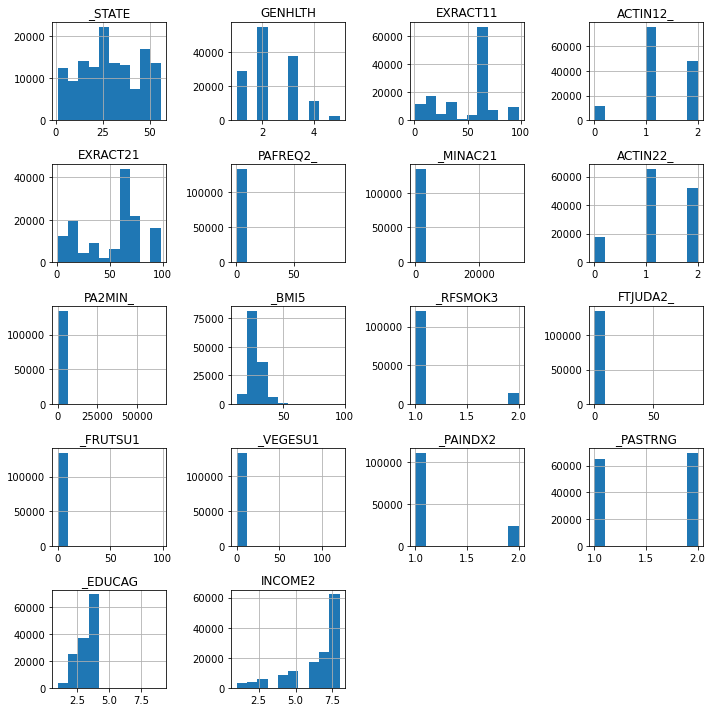

In [5]:
#now look at distributions of the features
df.hist(figsize=(10, 10));
plt.tight_layout();

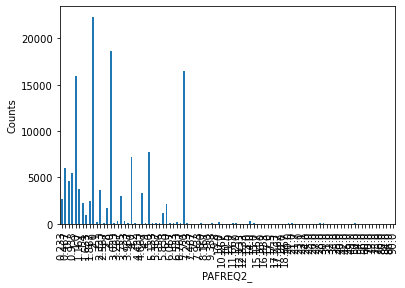

In [6]:
#Look more closely at the features with odd ranges
#check the distribution of target
feat = df['PAFREQ2_']
(feat.value_counts()
  .sort_index()
  .plot(kind='bar'));
plt.ylabel('Counts');
plt.xlabel('PAFREQ2_');

In [7]:
df['PAFREQ2_'].max() - df['PAFREQ2_'].min() 

89.767

In [8]:
#looks like there are quite a few extreme outliers in several columns, this aligns with what I noticed earlier

In [9]:
#remove all outliers
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df = df.dropna(how="any")

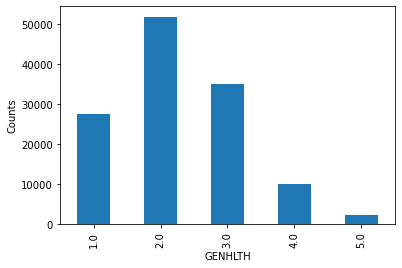

In [10]:
#check the distribution of target
y = df.pop('GENHLTH')
(y.value_counts()
  .sort_index()
  .plot(kind='bar'));
plt.ylabel('Counts');
plt.xlabel('GENHLTH');

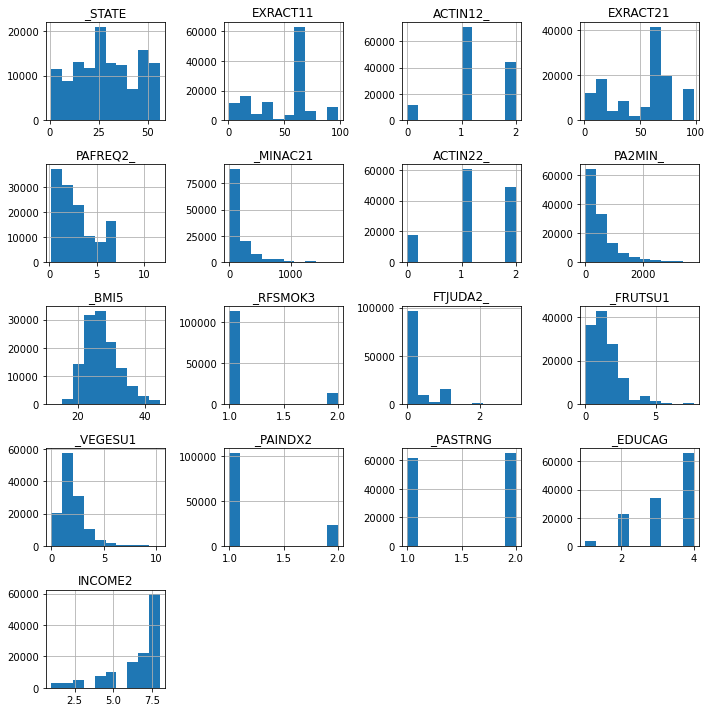

In [11]:
#look at distributions of the features again
df.hist(figsize=(10, 10));
plt.tight_layout();

In [12]:
#Use standard scaler on the more gaussian-like columns and power transformer on the others

gaussian_columns = ['_STATE', 'EXRACT11', 'ACTIN12_', 'EXRACT21', 'ACTIN22_', '_BMI5', '_VEGESU1']
power_columns = ['PAFREQ2_', '_MINAC21', 'PA2MIN_', '_RFSMOK3', 'FTJUDA2_', '_FRUTSU1', '_PAINDX2', '_PASTRNG', '_EDUCAG', 'INCOME2']
column_transformer = ColumnTransformer([
    ('gaussian', StandardScaler(), gaussian_columns),
    ('power', PowerTransformer(), power_columns)
])

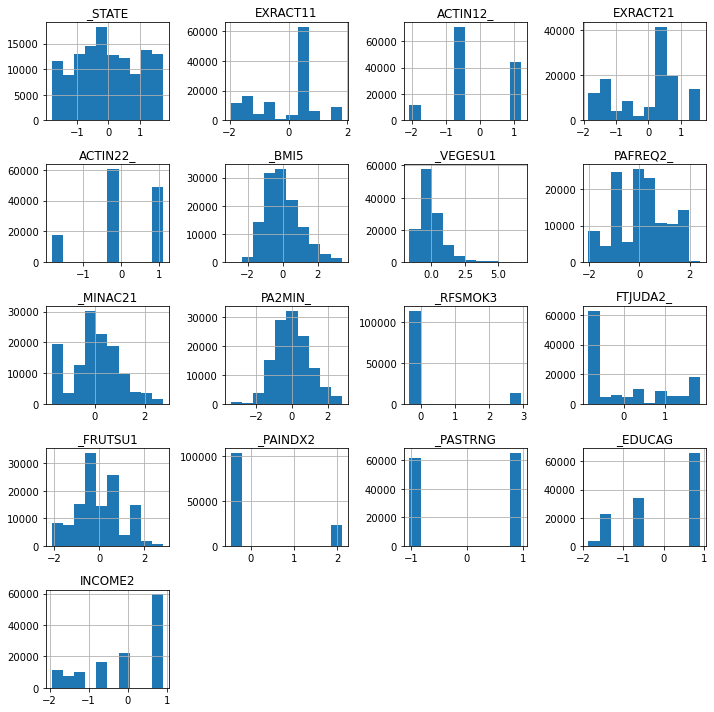

In [13]:
X_trans = column_transformer.fit_transform(df)
(pd.DataFrame(X_trans,
              columns=gaussian_columns + power_columns)
   .hist(figsize=(10, 10)));
plt.tight_layout();

In [14]:
#fit to scale and split data
y = y.values.astype(np.long).reshape(-1, 1)
# Map y from (3-8) to (0-5)
y -= y.min()

X = df

(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, test_size=0.33,
                                     stratify=y, random_state=666)

In [16]:
#train the model 

num_features = len(gaussian_columns + power_columns)
#step one in ordinal regression is a model that predicts a single scalar value, to do so create a simple two-layer neural network with pytorch
predictor = nn.Sequential(
    nn.Linear(num_features, num_features),
    nn.ReLU(inplace=True),
    nn.Linear(num_features, num_features),
    nn.ReLU(inplace=True),
    nn.Linear(num_features, 1, bias=False)
)

In [18]:
#with spacecutter, wrap this predictor with the ordinalLogisticModel to create cutpoints and pass the predictor output through the cumulative logistic link function
from spacecutter.models import OrdinalLogisticModel

num_classes = len(np.unique(y))
model = OrdinalLogisticModel(predictor, num_classes)

X_tensor = torch.as_tensor(X_train.values.astype(np.float32))

predictor_output = predictor(X_tensor).detach()
model_output = model(X_tensor).detach()

print(predictor_output)
print(model_output)

tensor([[ -6.7683],
        [-17.4750],
        [ -8.9416],
        ...,
        [ -1.0672],
        [-20.5073],
        [-15.7877]])
tensor([[9.9158e-01, 5.3080e-03, 1.9670e-03, 7.2557e-04, 4.2278e-04],
        [1.0000e+00, 1.1921e-07, 1.1921e-07, 0.0000e+00, 0.0000e+00],
        [9.9903e-01, 6.1023e-04, 2.2471e-04, 8.2612e-05, 4.8161e-05],
        ...,
        [2.8236e-01, 2.3444e-01, 2.2727e-01, 1.4361e-01, 1.1233e-01],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 7.1526e-07, 2.3842e-07, 1.1921e-07, 0.0000e+00]])


In [20]:
#train the model using skorck which wraps the model above and makes it compatible with the sci-kit learn estimator
from spacecutter.losses import CumulativeLinkLoss
from spacecutter.callbacks import AscensionCallback


skorch_model = NeuralNet(
    module=OrdinalLogisticModel,
    module__predictor=predictor,
    module__num_classes=num_classes,
    criterion=CumulativeLinkLoss,
    max_epochs=100,
    optimizer__type=torch.optim.Adam,
    optimizer__weight_decay=0.0,
    lr=0.1,
    device='cpu',
    callbacks=[
        ('ascension', AscensionCallback()),
    ],
    train_split=None,
    verbose=0,
)

In [21]:
#package it all up in the sci-kit learn pipelne (for spacecutter a transformer is required to make sure the matrices are floats and not doubles before being passed into the skorch model)

def to_float(x):
    return x.astype(np.float32)

pipeline = Pipeline([
    ('column', column_transformer),
    ('caster', FunctionTransformer(to_float)),
    ('net', skorch_model)
])

In [22]:
#use mean absolute error as scoring critera and do a grid search across number of epochs, learning rate, and weight decay
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred.argmax(axis=1))

scoring = make_scorer(mae_scorer,
                      greater_is_better=False,
                      needs_proba=True)

In [23]:
#set up the paramater grid
param_grid = {
    'net__max_epochs': np.logspace(1, 3, 5).astype(int),
    'net__lr': np.logspace(-4, -1, 5),
    'net__optimizer__weight_decay': np.logspace(-6, -2, 4)
}

sc_grid_search = GridSearchCV(
    pipeline, param_grid, scoring=scoring,
    n_jobs=None, cv=5, verbose=1
)
sc_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


TypeError: __init__() got an unexpected keyword argument 'type'

In [24]:
#do it with just mord alone
from mord.threshold_based import LogisticAT

pipeline = Pipeline([
    ('column', column_transformer),
    ('caster', FunctionTransformer(to_float)),
    ('model', LogisticAT())
])

In [27]:
param_grid = {
    'model__max_iter': np.logspace(3, 5, 5).astype(int),
    'model__alpha': np.logspace(0, 4, 5)
}

mord_grid_search = GridSearchCV(
    pipeline, param_grid, scoring=scoring,
    n_jobs=None, cv=5, verbose=1
)
mord_grid_search.fit(X_train, y_train.ravel()) #added ravel after warning appeared as my y_train was a numpy_array (column vector) and not a 1d array

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column',
                                        ColumnTransformer(transformers=[('gaussian',
                                                                         StandardScaler(),
                                                                         ['_STATE',
                                                                          'EXRACT11',
                                                                          'ACTIN12_',
                                                                          'EXRACT21',
                                                                          'ACTIN22_',
                                                                          '_BMI5',
                                                                          '_VEGESU1']),
                                                                        ('power',
                                                                         P

In [31]:
cutpoints = (mord_grid_search
             .best_estimator_
             .named_steps['model']
             .theta_)
print(f"Cutpoints: {cutpoints}")

Cutpoints: [-1.40550164  0.56260674  2.41205106  4.22693883]


In [32]:
y_pred = mord_grid_search.predict(X_test)

In [33]:
print(f'accuracy = {accuracy_score(y_test.squeeze(), y_pred):1.3f}')
print(f'MSE = {mean_absolute_error(y_test.squeeze(), y_pred):1.3f}')

accuracy = 0.436
MSE = 0.648


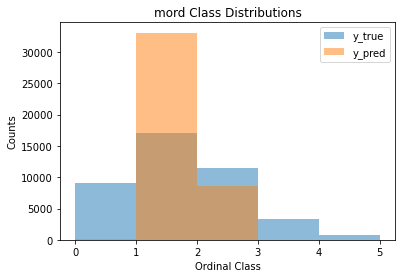

In [34]:
bins = np.arange(6)
plt.hist(y_test, bins=bins, alpha=0.5);
plt.hist(y_pred, bins=bins, alpha=0.5);
plt.legend(['y_true', 'y_pred']);
plt.ylabel('Counts');
plt.xlabel('Ordinal Class');
plt.title('mord Class Distributions');